# Телеком


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное [[хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Цель проекта

Создать модель машинного обучения, которая способна с высокой вероятностью предсказывать возможный уход клиента, чтобы компания могла попытаться его удержать заранее предложив промокоды и специальные условия.   
  
Целевая метрика ROC-AUC >= 0.85 и accuracy.  

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> Хорошо, когда есть подробное описание проекта и поставлена цель — так постороннему человеку будет проще ознакомиться!   
    
</div>

# Исследовательский анализ данных

Для начала импортируем пакеты и загрузим датасет

In [157]:
import os
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from phik.report import plot_correlation_matrix
import warnings

warnings.filterwarnings('ignore')

In [54]:
RANDOM_STATE = 220523

<div class="alert alert-danger">
<b>🚫 Комментарий тимлида:</b> Добавь пожалуйста обработку исключений, чтобы датасеты загружались на сервере Яндекс, например:
    
    /datasets/personal_new.csv
    
</div>

<div class="alert alert-info"> <b>Комментарий студента: </b> Исправил. </div>

<div class="alert alert-success">
<b>✔️ Комментарий тимлида v2:</b> Отлично!
    
</div>

In [55]:
BASE_DIR = os.getcwd()

try:
    df_contract = pd.read_csv(f"{BASE_DIR}/datasets/contract_new.csv")
    df_internet = pd.read_csv(f"{BASE_DIR}/datasets/internet_new.csv")
    df_personal = pd.read_csv(f"{BASE_DIR}/datasets/personal_new.csv")
    df_phone = pd.read_csv(f"{BASE_DIR}/datasets/phone_new.csv")
except FileNotFoundError:
    df_contract = pd.read_csv("/datasets/contract_new.csv")
    df_internet = pd.read_csv("/datasets/internet_new.csv")
    df_personal = pd.read_csv("/datasets/personal_new.csv")
    df_phone = pd.read_csv("/datasets/phone_new.csv")

Изучим датафреймы

### df_contract

In [56]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [57]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [58]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Датафрейм содержит следующие признаки:
- `customerID` - идентификатор пользователя (ключ по которому объединяются таблицы);
- `BeginDate` - дата заключения договора;
- `EndDate` - дата закрытия договора (если абонент отказался от услуг провайдера, по сути это и есть целевой признак);
- `Type` - тип контракта по длительности периода оплаты (ежемесячная оплата, ежегодная оплата, оплата каждые два года);
- `PaperlessBilling` - тип получения квитанции об оплате;
- `PaymentMethod` - способ оплаты услуг;
- `MonthlyCharges` - стоимость услуг в пересчёте на месяц;
- `TotalCharges` - суммарная стоимость услуг за весь период.

### df_personal

In [59]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Датафрейм содержит следующие признаки:
- `customerID` - идентификатор пользователя (ключ по которому объединяются таблицы);
- `gender` - пол абонента;
- `seniorCitizen` - является ли абонент пенсионером по возрасту;
- `Partner` - наличие/отсутствие партнёра;
- `Dependents` - наличие/отсутствие иждевенцев.

In [60]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### df_internet

In [61]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [62]:
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [63]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Датафрейм содержит следующие признаки:
- `customerID` - идентификатор пользователя (ключ по которому объединяются таблицы);
- `InternetService` - тип подключения (DSL, fiber optic);
- `OnlineSecurity` - блокировка небезопасных сайтов;
- `OnlineBackup` - облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` - антивирус;
- `TechSupport` - выделенная линия технической поддержки;
- `StreamingTV`- стриминговое телевидение;
- `StreamingMovies`- каталог фильмов.  

Кроме `customer_ID` все признаки датафрейма бинарные и могут быть преобразованы в булевый тип данных.

### df_phone

In [64]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [65]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Датафрейм содержит следующие признаки:
- `customerID` - идентификатор пользователя (ключ по которому объединяются таблицы);
- `MultipleLines` - количество линий домашней телефонии подключенных у абонента - одна/более одной.

Проверим дубликаты.

In [66]:
print(df_contract.duplicated().sum())
print(df_personal.duplicated().sum())
print(df_internet.duplicated().sum())
print(df_phone.duplicated().sum())

0
0
0
0


Дубликаты в данных отсутствуют.

Проверим совпадает ли количество `customerID` 

In [67]:
print(len(df_contract['customerID'].unique()))
print(len(df_personal['customerID'].unique()))
print(len(df_internet['customerID'].unique()))
print(len(df_phone['customerID'].unique()))

7043
7043
5517
6361


Количество `customerID` одинаковое в датафреймах `df_contract` и `df_personal`, первый содержит информацию о договоре, а второй персональные данные клиента. В двух других датасетах, а именно `internet_new.csv` — информация об интернет-услугах и `phone_new.csv` — информация об услугах телефонии количество записей меньше. Т.к. не все пользователи пользуются всеми предоставляемыми услугами в этих датафреймах закономерно меньше объектов.

Пропуски и дубликаты в данных отсутствуют.  
Заголовки не приведены к единому стандарту.  
Типы зачастую не соответствует сути хранимых данных.  
Все датафремы необходимо объединить в один по ключу `customerID`.
Из датафрейма `df_contract` необходимо выделить целевой признак. Если в столбце `EndDate` указана дата, значит абонент ушёл из компании. В той же таблице есть столбец `BeginDate`, мы можем получить количество дней когда абонент был клиентом компании и удалить оба исходных признака.
  
Почти все признаки бинарные категориальные, целесообразно обработать их OHE энкодером.  

## Предобработка данных

Объединим датафреймы в один

In [68]:
df = df_contract.merge(df_personal, on = 'customerID')
df = df.merge(df_internet, on = 'customerID', how = 'left')
df = df.merge(df_phone, on = 'customerID', how = 'left')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Удалим `customerID` т.к. он нам больше не понадобиться, он использовался только для объединения таблиц.

In [70]:
df = df.drop('customerID', axis=1)

In [71]:
df.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'],
      dtype='object')

Приведём заголовки к `camelCase`

In [72]:
df.columns = df.columns.str[0].str.lower() + df.columns.str[1:]

In [73]:
df.columns

Index(['beginDate', 'endDate', 'type', 'paperlessBilling', 'paymentMethod',
       'monthlyCharges', 'totalCharges', 'gender', 'seniorCitizen', 'partner',
       'dependents', 'internetService', 'onlineSecurity', 'onlineBackup',
       'deviceProtection', 'techSupport', 'streamingTV', 'streamingMovies',
       'multipleLines'],
      dtype='object')

Преобразуем типы данных.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   beginDate         7043 non-null   object 
 1   endDate           7043 non-null   object 
 2   type              7043 non-null   object 
 3   paperlessBilling  7043 non-null   object 
 4   paymentMethod     7043 non-null   object 
 5   monthlyCharges    7043 non-null   float64
 6   totalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   seniorCitizen     7043 non-null   int64  
 9   partner           7043 non-null   object 
 10  dependents        7043 non-null   object 
 11  internetService   5517 non-null   object 
 12  onlineSecurity    5517 non-null   object 
 13  onlineBackup      5517 non-null   object 
 14  deviceProtection  5517 non-null   object 
 15  techSupport       5517 non-null   object 
 16  streamingTV       5517 non-null   object 


Т.к. все категориальные признаки мы будем преобразовывать с помощью OHE, сейчас нам необходимо привести `totalCharges` к типу `float`, а также `beginDate` и `endDate` к типу `datetime`.

In [75]:
df['totalCharges'] = df['totalCharges'].replace(" ", 0).astype('float32')

Выделим целевой признак из `beginDate`, если объект содержит значение `No`, значит действие договора не прекращено и значение целевого признака `0`, иначе `1`

In [76]:
df['exited'] = np.where(df['endDate'] == 'No', 0, 1)

Столбец `endDate` содержит значения `No`, если действие договора ещё не прекращено. Так как информация актуальна на 1 февраля 2020, то заменим No в `EndDate` на эту дату.

In [77]:
df['endDate'] = df['endDate'].replace('No', '2020-02-01 00:00:00')
df['endDate'] = pd.to_datetime(df['endDate'], format='%Y-%m-%d')
df['beginDate'] = pd.to_datetime(df['beginDate'], format='%Y-%m-%d')

Создадим признак с продолжительностью действия договора в месяцах.

In [78]:
df['contractDurationMonths'] = (df['endDate'] - df['beginDate'])/np.timedelta64(1, 'M')

Удалим лишние признаки `beginDate`, `endDate`

In [79]:
df = df.drop(['beginDate', 'endDate'], axis=1)

Мы можем облегчить числовые типы данных.

In [80]:
float_cols = df.select_dtypes('float').columns
int_cols = df.select_dtypes('integer').columns

df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

До объединения количество объектов в таблицах не совпадало, в итоговом датафрейме должны были появиться пропуски.

In [81]:
df.isna().sum()

type                         0
paperlessBilling             0
paymentMethod                0
monthlyCharges               0
totalCharges                 0
gender                       0
seniorCitizen                0
partner                      0
dependents                   0
internetService           1526
onlineSecurity            1526
onlineBackup              1526
deviceProtection          1526
techSupport               1526
streamingTV               1526
streamingMovies           1526
multipleLines              682
exited                       0
contractDurationMonths       0
dtype: int64

Для кодирования категориальных признаков мы можем примернить `OHE` и заодно заполнить пропуски, но так как в планах использовать кросс-валидацию мы сделаем это непосредственно на этапе обучения модели в пайпалайне, а теперь проведём исследователький анализ данных.

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> Предварительный анализ данных выполнен успешно! Видно, что потребуется предобработка данных
    
</div>

# План работ

1. Провести исследовательский анализ данных:
- проанализировать каждый признак в разрезе классов целевого признака.
2. Закончить предобработку данных:
- сгенерировать дополнительные признаки;
- разделить выборку на фичи и таргет.
3. Обучить модели:
- создать пайплан на основе gridsearchcv. Перед обучением модели использовать one-hot encoder и масштабирование признаков для линейных моделей, также внутри пайплайна необходимо сбаллансировать классы.
- обучить линейную регрессию, случайный лес и кетбуст (кетбуст можно использовать без пайплайна), в качестве функции потерь используем ROC-AUC;
- выбираем лучшую модель, строим ROC кривую и определяем оптимальный порог;
- лучшую модель проверяем на тестовой выборке и сравниваем с константной моделью.
4. Сделать выводы по проведённой работе.

<div class="alert alert-warning">
<b>⚠️ Комментарий тимлида:</b> В целом по плану работ все хорошо, но нужно добавить некоторые уточнения:
    
- необходимо сгенерировать дополнительные признаки
    
- провести исследовательский анализ данных перед обучением моделей
    
</div>

<div class="alert alert-info"> <b>Комментарий студента: </b> Исправил. </div>

<div class="alert alert-warning">
<b>⚠️ Комментарий тимлида v2:</b> Все пункты на месте, только исследовательский анализ нужно сделать после предобработки =)
    
Без целевого признака смысла проводить анализ нет
    
</div>

**К тимлиду вопросов не имею, задача ясна.**

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> 👍
    
</div>

<div class='alert alert-success'>
<b>✔️ Комментарий тимлида v2:</b> План работ принят, можно приступать к основному проекту. 
    
Пожалуйста сохрани наши с тобой комментарии, а проект продолжай делать в этом же документе, успехов!
    
</div>

### Анализ данных

Проверим дисбаланс целевой переменной

In [82]:
df['exited'].value_counts()

0    5942
1    1101
Name: exited, dtype: int64

Целевая переменная не сбалансированна, неободимо учесть это на этапе обучения модели и добавить балансировку классов в пайплайн.

### Исследование количественных признаков

Попробуем понять как влияют количественные признаки (месячная и суммарная стоимость услуг) на целевой признак.

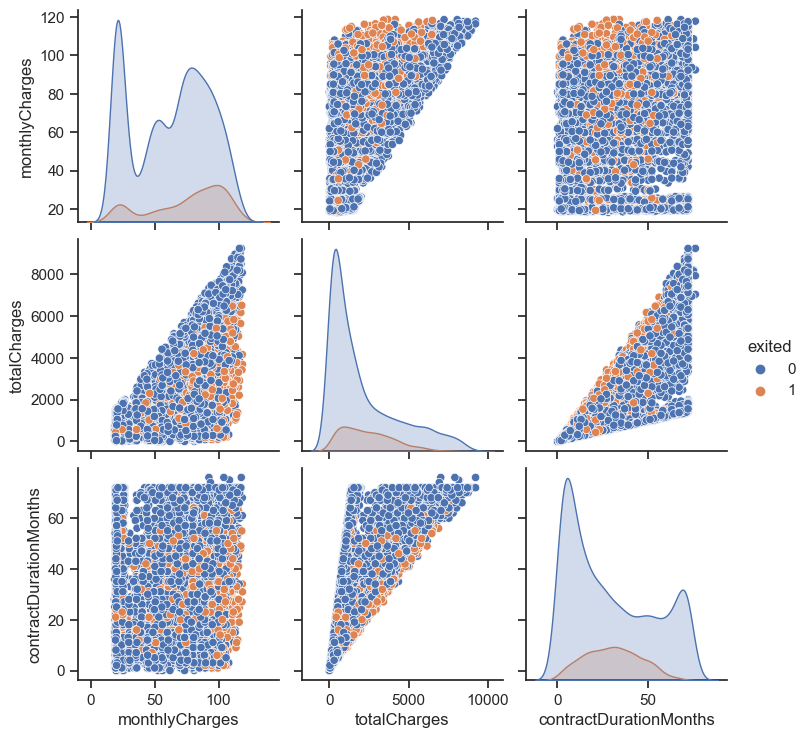

In [83]:
sns.set_theme(style="ticks")
sns.pairplot(df[['monthlyCharges', 
                 'totalCharges', 
                 'contractDurationMonths', 
                 'exited']], 
                 hue='exited')
plt.show()

"Кластер" ушедших клиентов можно описать следующими утверждениями:  
1. Месячный взнос ушедших клиентов был больше, чем тех, кто не остался. Клиенты, с низкой ежемесечной оплатой за услуги склонны уходить реже;  
2. Чаще всего клиенты уходили примерно на 30м месяце.  

Рассмотрим последнее утверждение подробней.  

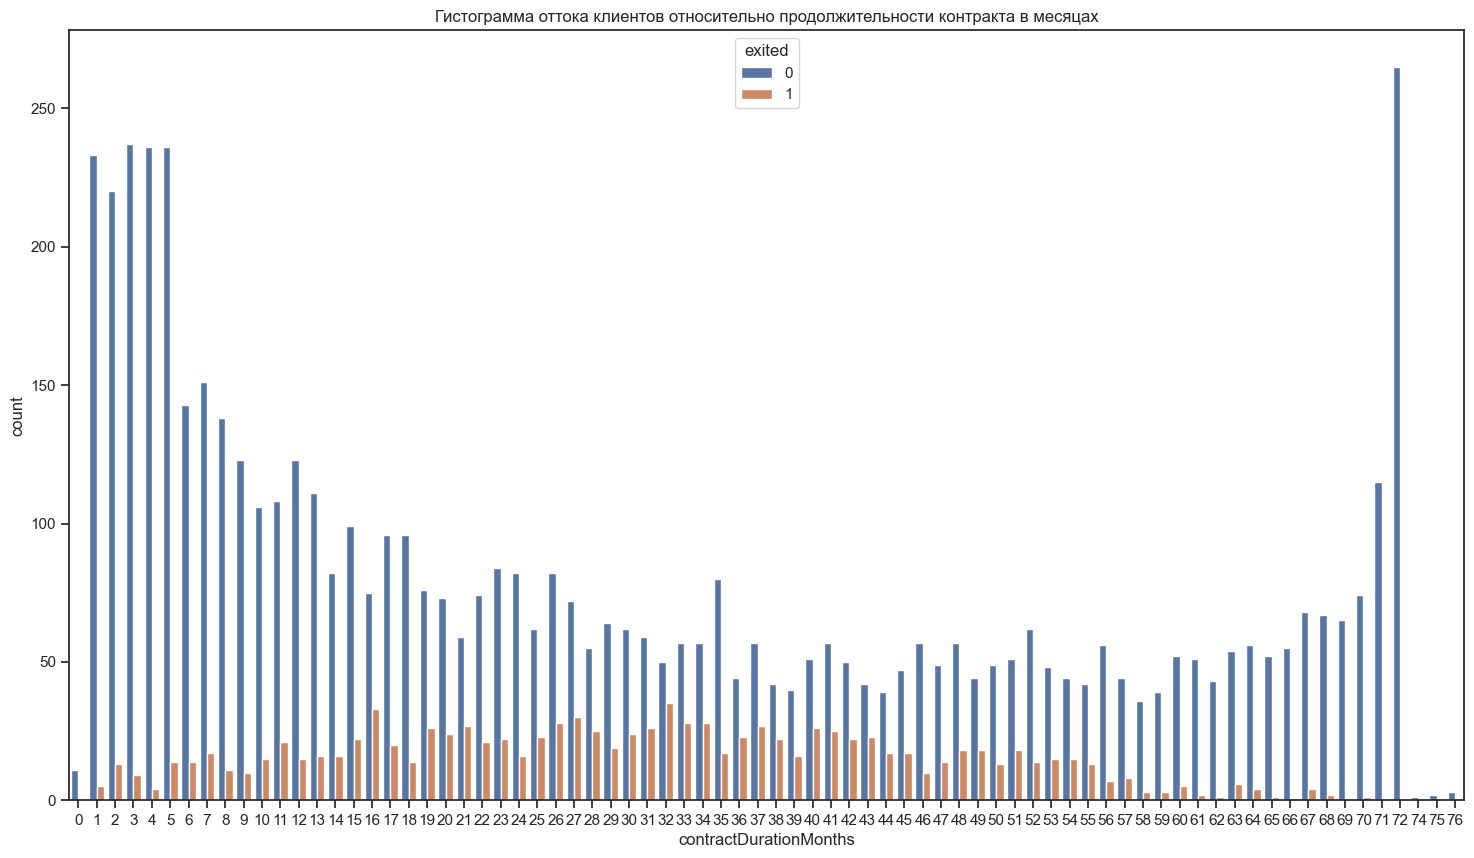

In [84]:
plt.figure(figsize=(18,10))
plt.title('Гистограмма оттока клиентов относительно продолжительности контракта в месяцах')
sns.countplot(
    x = round(df['contractDurationMonths']).astype('int'), 
    hue = df['exited']
)
plt.show()

In [85]:
df[df['exited']==1]['contractDurationMonths'].describe()

count    1101.000000
mean       30.386307
std        15.072883
min         0.919937
25%        18.957268
50%        30.062220
75%        41.035751
max        69.948051
Name: contractDurationMonths, dtype: float64

В среднем пользователи расторгают договор на тридцатом месяце пользования услугами.  
Чем меньше продолжительность действия договора, тем меньше вероятность того что клиент уйдёт, также после 30 месяцев количество пользователей расторгших договор постепенно уменьшается.  
Не представляется возможным проинтерпетировать такое распределение оттока клиентов, кроме как предположить, что в нашем распоряжении странные синтетические данные.  

### Исследование категориальных признаков

In [86]:
cats = ['type', 'paperlessBilling', 'paymentMethod', 'gender', 'seniorCitizen', 'partner', 'dependents', 'internetService', 'onlineSecurity', 'onlineBackup', 'deviceProtection', 'techSupport', 'streamingTV', 'streamingMovies', 'multipleLines']

TYPE


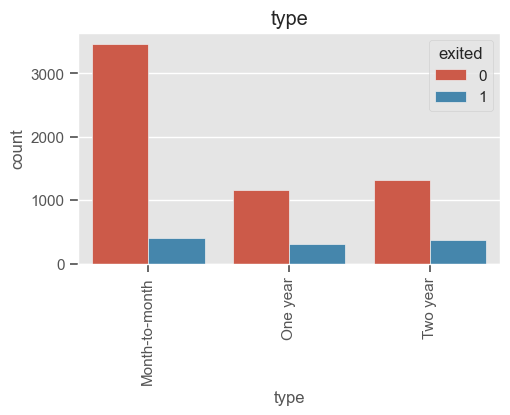

,Not Exited,Exited
type,,
Month-to-month,89.50,10.50
One year,78.75,21.25
Two year,77.52,22.48


PAPERLESSBILLING


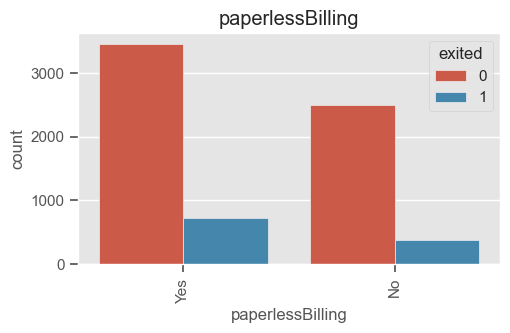

,Not Exited,Exited
paperlessBilling,,
No,86.77,13.23
Yes,82.71,17.29


PAYMENTMETHOD


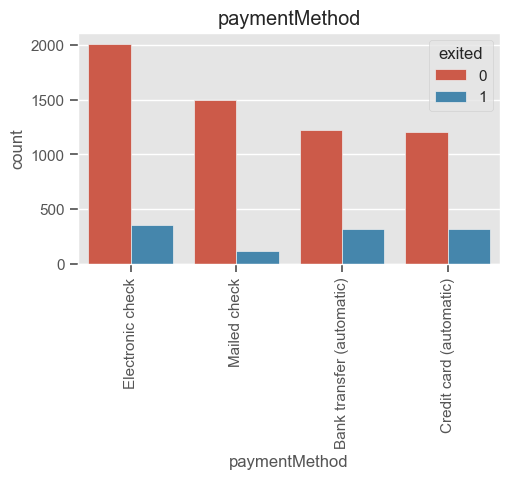

,Not Exited,Exited
paymentMethod,,
Bank transfer (automatic),79.47,20.53
Credit card (automatic),79.17,20.83
Electronic check,85.20,14.80
Mailed check,92.74,7.26


GENDER


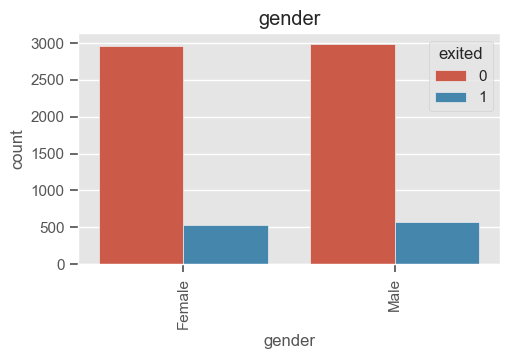

,Not Exited,Exited
gender,,
Female,84.86,15.14
Male,83.88,16.12


SENIORCITIZEN


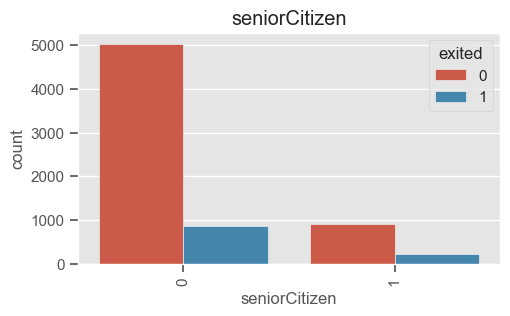

,Not Exited,Exited
seniorCitizen,,
0,85.27,14.73
1,79.68,20.32


PARTNER


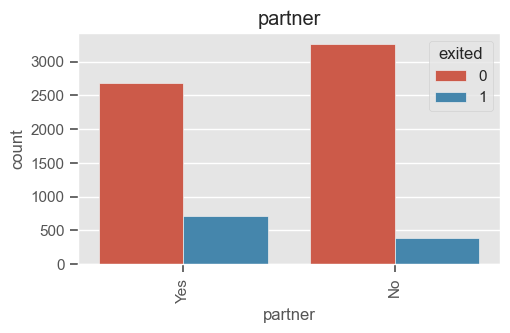

,Not Exited,Exited
partner,,
No,89.51,10.49
Yes,78.87,21.13


DEPENDENTS


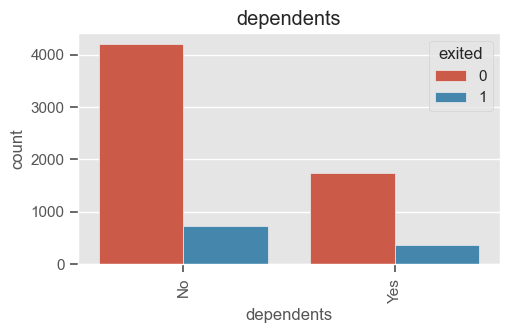

,Not Exited,Exited
dependents,,
No,85.14,14.86
Yes,82.56,17.44


INTERNETSERVICE


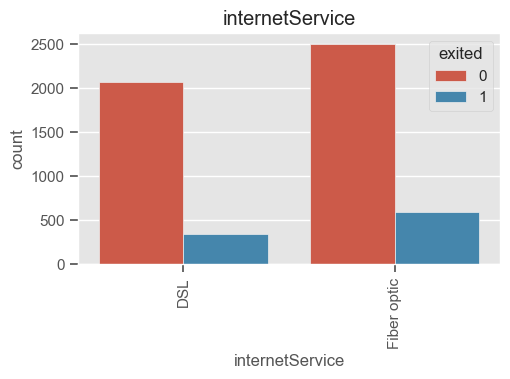

,Not Exited,Exited
internetService,,
DSL,85.71,14.29
Fiber optic,80.78,19.22


ONLINESECURITY


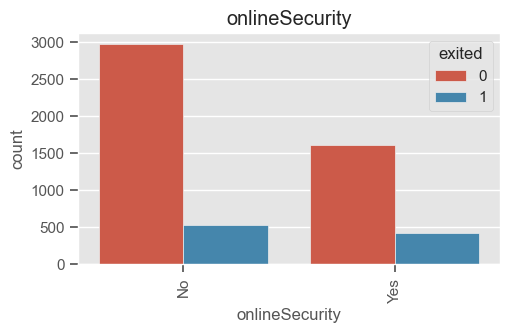

,Not Exited,Exited
onlineSecurity,,
No,84.96,15.04
Yes,79.45,20.55


ONLINEBACKUP


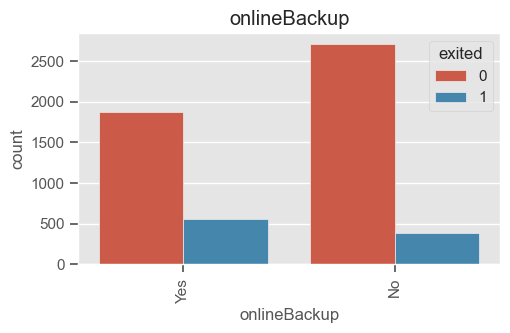

,Not Exited,Exited
onlineBackup,,
No,87.66,12.34
Yes,76.95,23.05


DEVICEPROTECTION


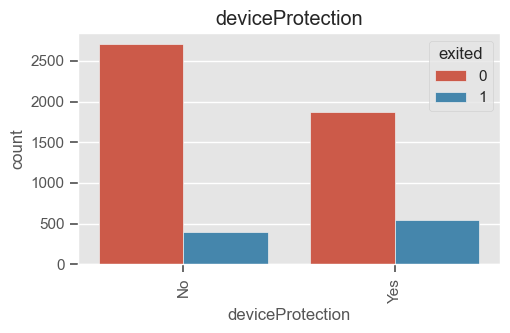

,Not Exited,Exited
deviceProtection,,
No,87.37,12.63
Yes,77.29,22.71


TECHSUPPORT


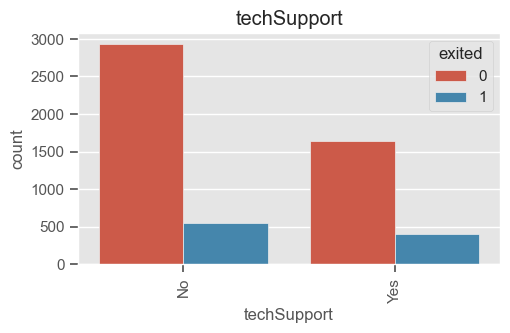

,Not Exited,Exited
techSupport,,
No,84.37,15.63
Yes,80.53,19.47


STREAMINGTV


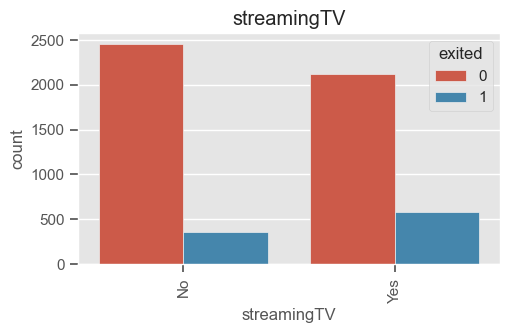

,Not Exited,Exited
streamingTV,,
No,87.30,12.70
Yes,78.43,21.57


STREAMINGMOVIES


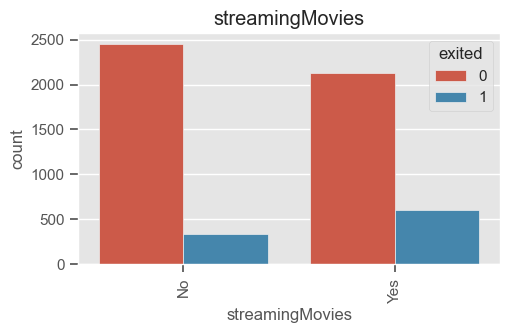

,Not Exited,Exited
streamingMovies,,
No,87.97,12.03
Yes,77.82,22.18


MULTIPLELINES


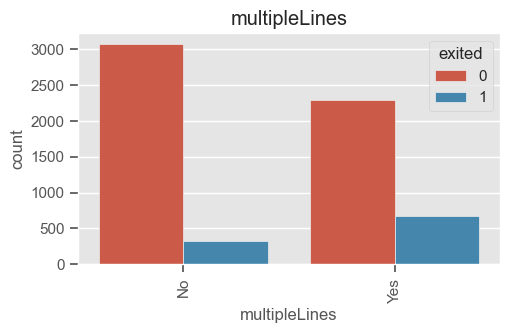

,Not Exited,Exited
multipleLines,,
No,90.56,9.44
Yes,77.18,22.82


In [87]:
plt.style.use("ggplot")
for column in cats:
    # заголовок
    print(column.upper())

    # вывод графика
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    sns.countplot(x=df[column], hue=df["exited"])
    plt.title(column)    
    plt.xticks(rotation=90)
    plt.show()

    # сводная таблица
    pivot_table = pd.crosstab(df[column], df['exited'], normalize='index')
    pivot_table.columns = ['Not Exited', 'Exited']
    pivot_table = round(pivot_table * 100, 2)
    display(pivot_table)

**`type` - тип подписки**  
Доля расторгнувших контракт в два раза больше среди тех у кого период оплаты составляет 1-2 года.  
  
**`paperlessBilling`**  
Среди тех кто получает чеки в электронном виде доля отказов больше (13.23% против 17.29%).  
  
**`paymentMethod`**  
Отток клиентов значительно отличается в зависимости от способа оплаты. Самый низкая доля расторгнувших договор у тех, кто получается квитанцию почтой (7,26%), в два раза выше (14,8%) у тех, кто получает электронную квитанцию и самый высокий показатель у тех, кто подключил автоматическую оплату банковским переводом и кредитной картой (20,53% и 20,83% соответственно).  

**`gender`**  
Для обоих полов доля расторгнувших контракт почти одинакова.  
  
**`seniorCitizen`**  
Персионеры на треть чаще отказываются от услуг, чем не пенсионеры. Что, возможно, происходит в силу естественных причин. В то время как доля пенсионеров примерно в пять раз ниже.  
  
**`partner`**
Клиенты без партнёров склонны в два раза чаще отказываться от услуг, чем клиенты с партнёрами.  
  
**`dependents`**  
А вот отсутствие иждевенцев практически не увеличивает вероятность отказа от услуг, различие примерно в 3%.  
  
**`internetService`**  
Пользователи оптоволокна отказываются от услуг чаще чем пользователи DSL, 19.22% и 14.29% соответственно.  
  
Что касается дополнительных услуг: `onlineSecurity`, `onlineBackup`, `deviceProtection`, `techSupport`, `stramingTV`, `stramingMovies`, `multipleLines`. Во всех случаях наличие услуги увеличивает вероятность расторжения договора на значение от 25 до 100% по сравнению с теми у кого услуга не подключена.

Проверим есть ли мультиколлениарность между признаками.

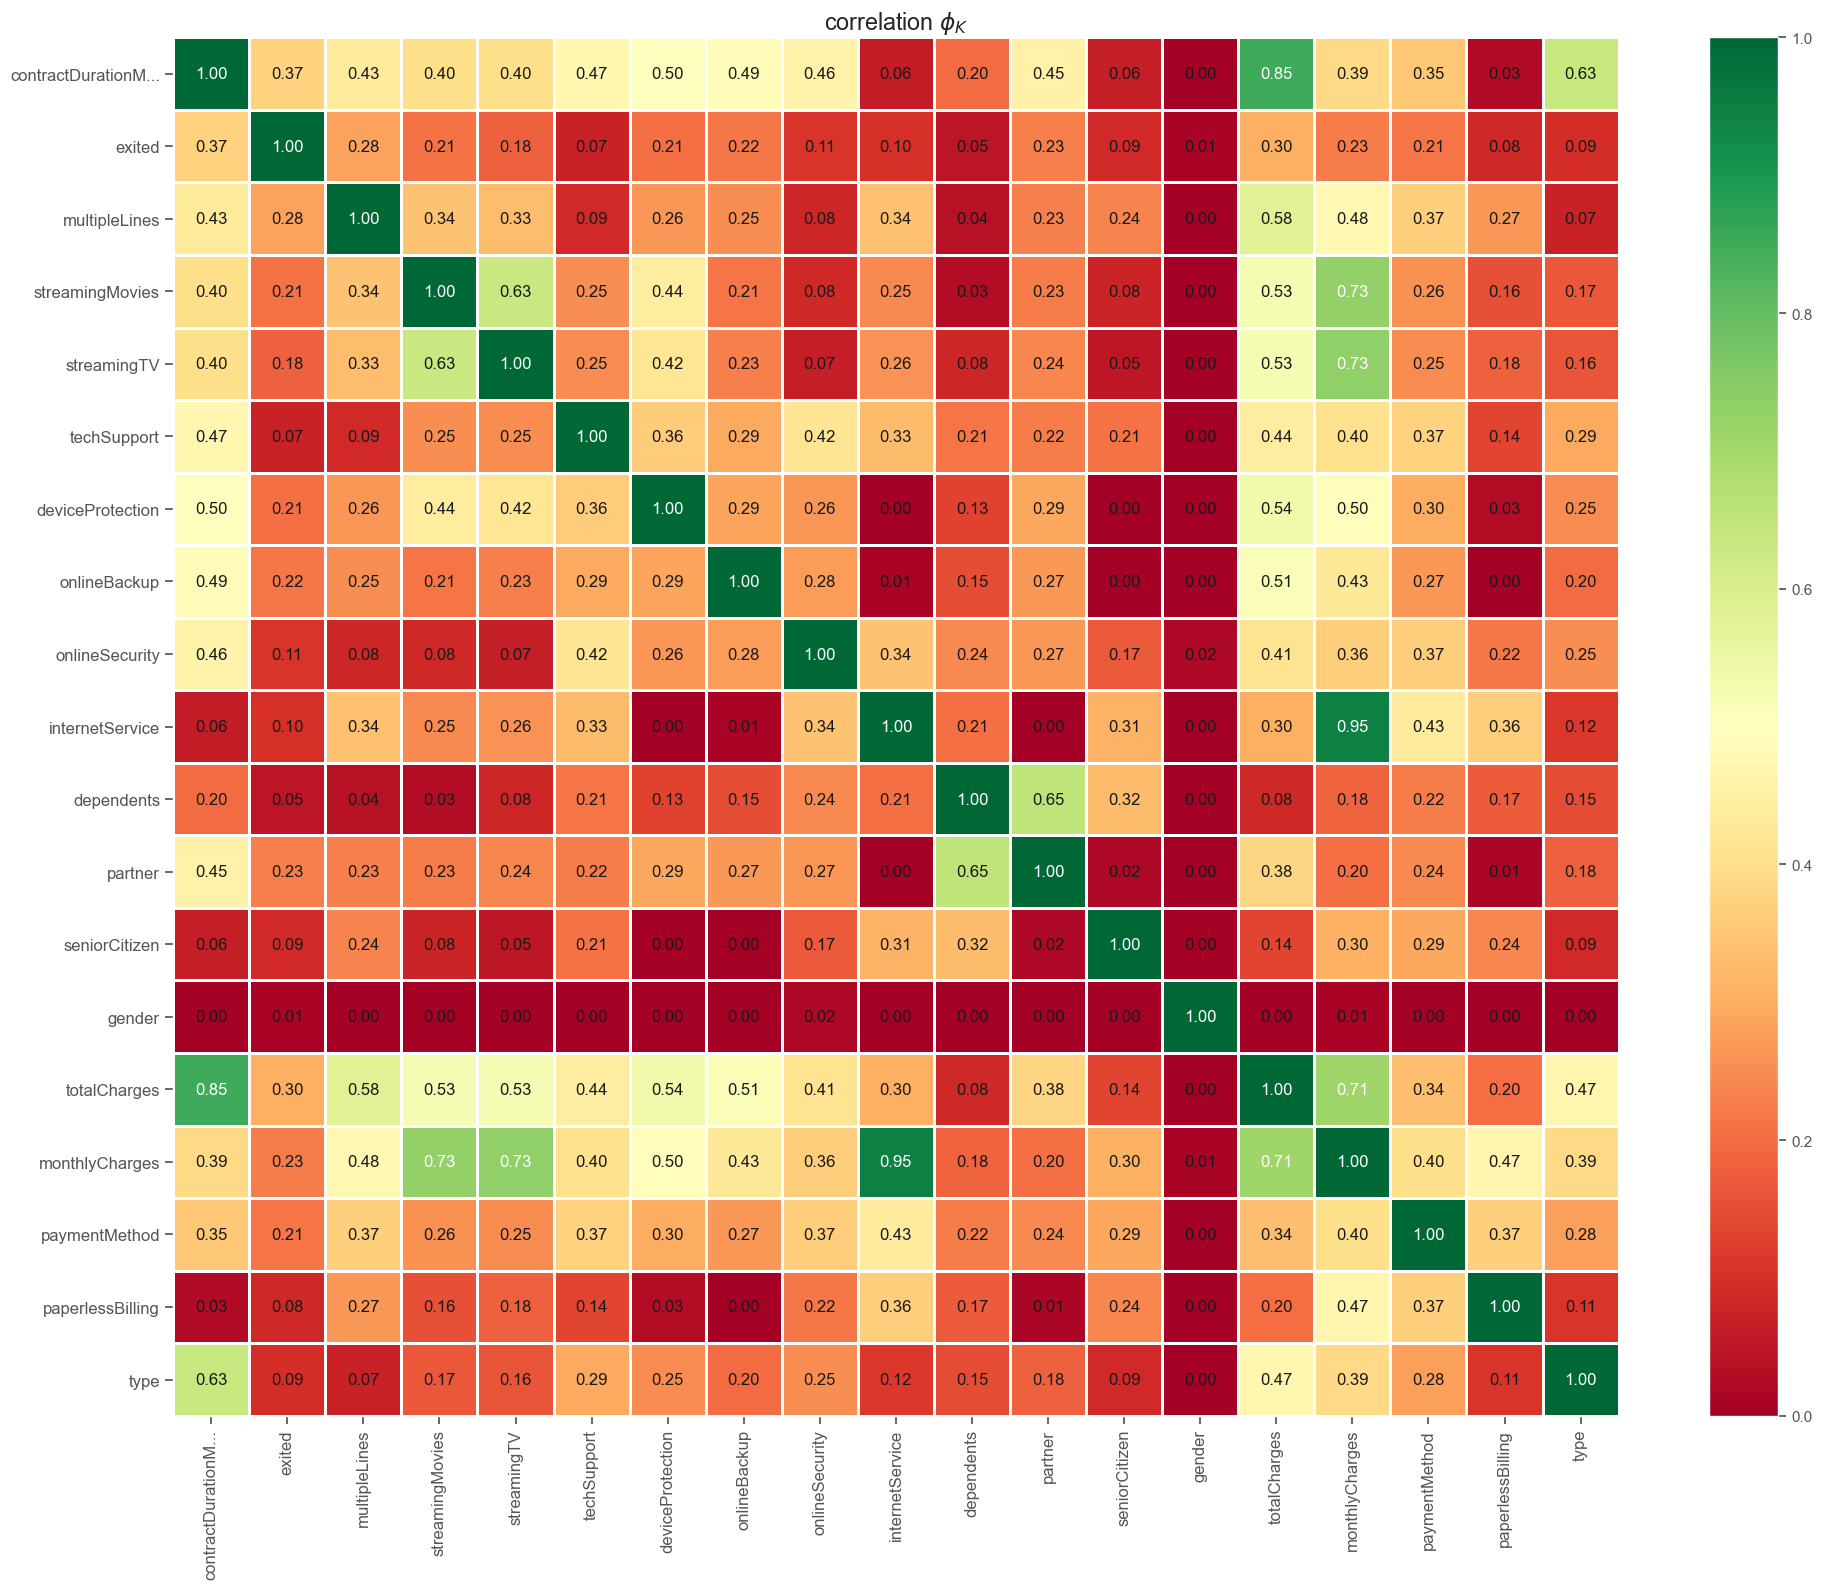

In [88]:
interval_cols = ['monthlyCharges', 'totalCharges', 'seniorCitizen', 'exited', 'contractDurationMonths']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, 
                        vmax=1, 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.2, 
                        figsize=(20, 16))
plt.tight_layout()
plt.show()

Между несколькими прнизаками есть мультиколлинеарность, однако мы будем использовать только одну линейную модель `Logisticegression` и можем использовать L2 регуляризацию для того чтобы решить проблему мультиколлинеарности. Оставим данные как есть.

Прежде, чем переходить к следующему этапу выделим из выборки целевой признак а также отделим тестовую выборку.

In [89]:
target = df['exited']
features = df.drop('exited', axis=1)
features_train, features_test, target_train, target_test = \
    train_test_split(
        features, 
        target, 
        test_size=0.25, 
        random_state=RANDOM_STATE
    )

## Вывод

**На основе анализа мы можем составить портрет типичных пользователей, которые отказались и не отказались от услуг:**  
- клиенты, которые оплачивают услуги с периодом в 1-2 года, имеют оптоволоконное подключение, оплачивают услуги автоплатежом, являются клиентами 30 месяцев и подключили дополнительные услуги чаще всего расторгают договор;  
- клиенты, которые только пришли в компанию или пользуются её услугами с самого начала, не подключают дополнительные услуги, оплачивают счета раз в месяц и получают квитанции в бумажном виде чаще предпочитают остаться.  

# Обучение модели

Мы не закончили всю запланированную предобработку данных, часть из этапов проведём в пайплайне, а именно масштабирование количественных признаков, кодирование категориальных и балансировку по классам целевого признака.

## LogisticRegression

Определим список количественных признаков для масштабирования

In [90]:
num_features = list(set(features.columns) - set(cats))
num_features

['contractDurationMonths', 'monthlyCharges', 'totalCharges']

In [91]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_features),
    ('ohe', OneHotEncoder(
        handle_unknown='ignore',
        drop='first',
        sparse=False, 
        dtype='int8'
    ), cats),
])

pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('regressor', LogisticRegression(random_state=RANDOM_STATE))
])

params = {
    'regressor__C' : [10, 1, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001],
    'regressor__penalty':['l2'], 
    'regressor__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

grid_lr = GridSearchCV(
    estimator=pipe_lr,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
)

grid_lr.fit(features_train, target_train)

print(f'ROC-AUC {grid_lr.best_score_}')
print(f'Best params {grid_lr.best_params_ }')

ROC-AUC 0.7555063859861668
Best params {'regressor__C': 0.1, 'regressor__penalty': 'l2', 'regressor__solver': 'lbfgs'}


## RandomForest

In [92]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_features),
    ('ohe', OneHotEncoder(
        handle_unknown='ignore',
        drop='first',
        sparse=False, 
        dtype='int8'
    ), cats),
])

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('regressor', RandomForestClassifier(random_state=RANDOM_STATE))
])

params = {
        'regressor__max_depth': range(1,20,1),
        'regressor__n_estimators': range(1,200,10),
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
)

grid_rf.fit(features_train, target_train)

print(f'ROC-AUC {grid_rf.best_score_}')
print(f'Best params {grid_rf.best_params_ }')

ROC-AUC 0.8083708483897489
Best params {'regressor__max_depth': 8, 'regressor__n_estimators': 191}


## Catboost

In [151]:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_features),
    ('ohe', OneHotEncoder(
        handle_unknown='ignore',
        drop='first',
        sparse=False, 
        dtype='int8'
    ), cats),
])

pipe_cb = Pipeline([
    ('preprocessor', preprocessor),
    # ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', CatBoostClassifier(
        verbose=500, 
        random_state=RANDOM_STATE, 
    ))
])

params = {
    'classifier__learning_rate': [0.1],
    'classifier__loss_function': ['Logloss'],
    'classifier__eval_metric' : ['AUC'],
    'classifier__depth': [3],
    'classifier__l2_leaf_reg': [0.15],
    'classifier__bagging_temperature': [0.3],
    'classifier__random_strength': [0.1],
    'classifier__scale_pos_weight' : [6],
    'classifier__iterations' : [2000],
    'classifier__min_data_in_leaf': [15],
    'classifier__grow_policy' : ['SymmetricTree'],
    'classifier__od_wait': [20]
}

grid_cb = GridSearchCV(
    pipe_cb, 
    params, 
    cv=4, 
    n_jobs=-1,
    scoring='roc_auc'
)   

grid_cb.fit(features_train, target_train)

print(f'ROC-AUC {grid_cb.best_score_}')
print(f'Best params {grid_cb.best_params_ }')

0:	total: 29ms	remaining: 58s
500:	total: 1.47s	remaining: 4.4s
1000:	total: 2.83s	remaining: 2.82s
1500:	total: 4.2s	remaining: 1.4s
1999:	total: 5.72s	remaining: 0us
ROC-AUC 0.9022772795271583
Best params {'classifier__bagging_temperature': 0.3, 'classifier__depth': 3, 'classifier__eval_metric': 'AUC', 'classifier__grow_policy': 'SymmetricTree', 'classifier__iterations': 2000, 'classifier__l2_leaf_reg': 0.15, 'classifier__learning_rate': 0.1, 'classifier__loss_function': 'Logloss', 'classifier__min_data_in_leaf': 15, 'classifier__od_wait': 20, 'classifier__random_strength': 0.1, 'classifier__scale_pos_weight': 6}


Лучшая модель - `CatBoostClassifier` с параметрами:  
`bagging_temperature` = 0.3  
`depth` = 3  
`eval_metric` = 'AUC'  
`grow_policy` = 'SymmetricTree'   
`iterations` = 2000   
`l2_leaf_reg` = 0.15   
`learning_rate` = 0.1   
`loss_function` = 'Logloss'   
`min_data_in_leaf` = 15   
`od_wait` = 20  
`random_strength` = 0.1  
`scale_pos_weight` = 6  

## Тестирование модели

Протестируем лучшую из полученных моделей на тестовой выборке.   
В первую очередь необходимо преобразовать тестовый датасет.  

In [152]:
preprocessor.fit(features_train)
features_test_transformed = preprocessor.transform(features_test)
model = grid_cb.best_estimator_
target_predicted = model.predict(features_test)
roc_auc = roc_auc_score(target_test, target_predicted)
print(f"ROC-AUC на тестовой выборке = {roc_auc}")

ROC-AUC на тестовой выборке = 0.8606163580970236


Результат на тестовой выборке соответствует условию `ROC-AUC >= 0.85`. Тест пройден.

Подберём порог для классификации.  
Взглянем на ROC-кривую.

<Figure size 500x500 with 0 Axes>

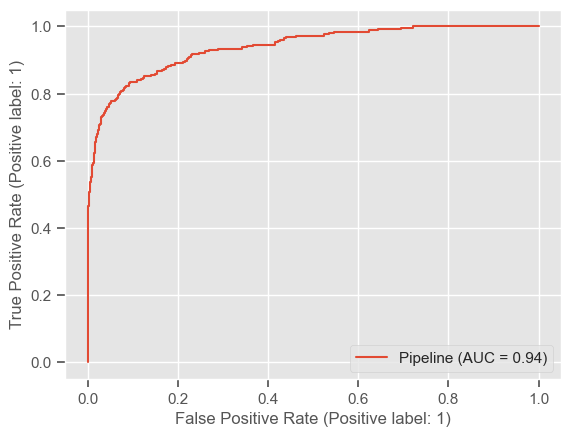

In [153]:
plt.figure(figsize=(5,5))
plot_roc_curve(model, features_test, target_test)
plt.show();

Подберём оптимальное пороговое значение

In [154]:
target_predicted_probabilities = model.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, target_predicted_probabilities)

# Находим индекс точки на графике, ближайшей к верхнему левому углу
index = np.argmax(np.abs(tpr - fpr))
# Определяем пороговое значение, соответствующее этой точке
threshold = thresholds[index]

print("Оптимальное пороговое значение:", threshold)

Оптимальное пороговое значение: 0.37966854317300214


Оценим `accuracy` при оптимальном пороговом значении

In [155]:
target_predicted = model.predict_proba(features_test)[:, 1] > threshold
accuracy = accuracy_score(target_test, target_predicted)
print(f"Accuracy на тестовой выборке = {accuracy:.2f}")

Accuracy на тестовой выборке = 0.90


Модель способна предсказывать возможный уход клиента в 90% случаев, чтобы компания смогла попытаться удержать его заранее предложив промокоды и специальные условия.   

## Проверка на адекватность

In [156]:
model = DummyClassifier(strategy='uniform')

model.fit(features_train, target_train)
target_predicted = model.predict(features_test)

roc_auc = roc_auc_score(target_test, target_predicted)
accuracy = model.score(target_test, target_predicted)

print(f"ROC-AUC: {roc_auc}")
print(f"Accuracy: {accuracy}")

ROC-AUC: 0.514229357081478
Accuracy: 0.4946053378762067


`DummyClassifier` закономерно показал результат ниже, чем каждая из обученных моделей, тест на адекватность пройден.

# Вывод

На первом этапе были проанализированы исходные данные. На основе анализа были созданы новые признаки, часть признаков были удалены. Данные были подготовлены к работе с моделями машинного обучения.  
  
На этапе обучения были обучены три различные модели. Лучше всего себя показала модель `CatBoostClassifier` с результатом `accuracy = 0.9` на тестовой выборке. Это значит, что модель способна предсказывать `90%` клиентов, которые намереваются уйти. Прогноз позволит компании предпринять необходимые меры для сохранения лояльности клиента.

**Отличия от плана:**  
Перед кетбустом пришлось применить OHE т.к. после объединения датасетов в них встречались пропущенные значения, а встроенный кодировщим с пропусками работать не хочет. Было принято решение закодировать с помощью OHE.    
В остальном работа выполнена в соответствии с планом.  